In [29]:
# use this to import from parent
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)


import numpy as np
import matplotlib.pyplot as plt 
import time
import pandas as pd 

import pyzx as zx

from ansatz_and_gates import *

In [18]:
nr_q = 10
depth= 50

params=[np.random.normal(0, 1, 1)[0] * 2 * np.pi for i in range(3*nr_q*depth)]


start = time.time()

circuit = zx.Circuit(qubit_amount = nr_q)
add_ansatz_hardwareefficient(circuit,nr_q,depth,params)
zx.draw(circuit)

create_c = time.time()
g=circuit.to_graph()
zx.draw(g)
convert_g= time.time()

zx.full_reduce(g, quiet=False) 
zx.draw(g)
optimize_g = time.time()

oc=zx.extract_circuit(g.copy())
zx.draw(oc)
extract_c=time.time()



spider_simp: 442. 49.  2 iterations
pivot_simp: 5. 2. 1.  3 iterations
lcomp_simp: 950. 441.  2 iterations


In [19]:
t_total=extract_c-start
t_create=create_c-start
t_convert=convert_g-create_c
t_optimize=optimize_g-convert_g
t_extract=extract_c-optimize_g

print("t_create: ",t_create)
print("t_convert: ",t_convert)
print("t_convert: ",t_convert)
print("t_optimize: ",t_optimize)
print("t_extract: ",t_extract)
print("t_total: ",t_total)

t_create:  0.09366297721862793
t_convert:  0.07582807540893555
t_convert:  0.07582807540893555
t_optimize:  0.2261669635772705
t_extract:  0.26633501052856445
t_total:  0.6619930267333984


In [20]:
def experiment1(nr_q,depth):
    params=[np.random.normal(0, 1, 1)[0] * 2 * np.pi for i in range(3*nr_q*depth)]


    start = time.time()

    circuit = zx.Circuit(qubit_amount = nr_q)
    add_ansatz_hardwareefficient(circuit,nr_q,depth,params)
    #zx.draw(circuit)

    create_c = time.time()
    g=circuit.to_graph()
    #zx.draw(g)
    convert_g= time.time()

    zx.full_reduce(g, quiet=True) 
    #zx.draw(g)
    optimize_g = time.time()

    oc=zx.extract_circuit(g.copy())
    #zx.draw(oc)
    extract_c=time.time()

    t_total=extract_c-start
    t_create=create_c-start
    t_convert=convert_g-create_c
    t_optimize=optimize_g-convert_g
    t_extract=extract_c-optimize_g
    
    return t_total ,t_create,t_convert,t_optimize,t_extract


In [22]:
def get_data(nr_q,depth,reps=1):
    t_total_m=0
    t_create_m=0
    t_convert_m=0
    t_optimize_m=0
    t_extract_m=0
    for i in range(reps):
        t_total,t_create,t_convert,t_optimize,t_extract=experiment(nr_q,depth)
        t_total_m+=t_total/reps
        t_create_m+=t_create/reps
        t_convert_m+=t_convert/reps
        t_optimize_m+=t_optimize/reps
        t_extract_m+=t_extract/reps
        
    return t_total_m ,t_create_m,t_convert_m,t_optimize_m,t_extract_m
    

In [50]:
nr_q=[]
depth=[]
t_total=[]
t_create=[]
t_convert=[]
t_optimize=[]
t_extract=[]
for q in range(15,36):
    for d in range(50):
        t_total_m ,t_create_m,t_convert_m,t_optimize_m,t_extract_m=get_data(q,d,reps=1)
        nr_q.append(q)
        depth.append(d)
        t_total.append(t_total_m)
        t_create.append(t_create_m)
        t_convert.append(t_convert_m)
        t_optimize.append(t_optimize_m)
        t_extract.append(t_extract_m)


In [51]:
df = pd.DataFrame()
df['nr_q']=nr_q
df['depth']=depth
df['t_total']=t_total
df['t_create']=t_create
df['t_convert']=t_convert
df['t_optimize']=t_optimize
df['t_extract']=t_extract
df.head()

,nr_q,depth,t_total,t_create,t_convert,t_optimize,t_extract
0,15,0,0.005512,0.000009,0.000755,0.001473,0.003275
1,15,1,0.036384,0.000669,0.003963,0.013489,0.018263
2,15,2,0.051380,0.000493,0.002436,0.020314,0.028137
3,15,3,0.050741,0.000400,0.002635,0.018966,0.028740
4,15,4,0.060918,0.000552,0.003443,0.023803,0.033120


In [52]:
def time_dept_plot(df,nr_q):
    plt.figure()
    depth=df[df['nr_q'] ==nr_q]['depth']

    #t_total= df[df['nr_q'] ==nr_q]['t_total']
    #plt.scatter(t_total,depth,label='t_total')

    t_create= df[df['nr_q'] ==nr_q]['t_create']
    plt.scatter(depth,t_create,label='t_create')

    t_convert= df[df['nr_q'] ==nr_q]['t_convert']
    plt.scatter(depth,t_convert,label='t_convert')


    t_optimize= df[df['nr_q'] ==nr_q]['t_optimize']
    plt.scatter(depth,t_optimize,label='t_optimize')

    t_extract= df[df['nr_q'] ==nr_q]['t_extract']
    plt.scatter(depth,t_extract,label='t_extract')


    plt.legend()
    plt.xlabel('depth')
    plt.ylabel('time')
    plt.title('time(depth) nr_q='+str(nr_q))
    plt.show()

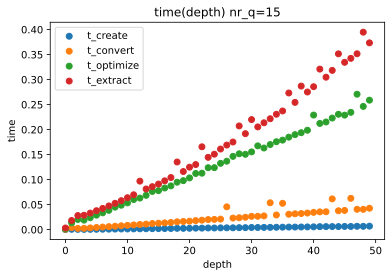

In [53]:
nr_q=15
time_dept_plot(df,nr_q)

In [54]:
#  circuit : add_ansatz_hardwareefficient
#  optimizer: zx.full_reduce 
#  extration: zx.extract_circuit
# OBS :
#-> a few regular spikes
#-> t_extract and t_optimize they are the most expensive
#-> I should do another ansatz after the extraction, we can say that the circuit is not optimized
#-> If ansatz is a repetitive structure, wouldn't be more efficient to optimize a layer and then 
#  use it as anew leyer. 
#  (For this we should somehow take into account how the parameters move in optimization. 
#  Or less efficiently we eliminate the part that eliminates the portions = 0 2pi etc and 
#  then we replace all the numbers with new parameters.)
#